In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
8,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
3,pretrained,hard_sine2sawtooth,Transformer,,10000,-1,20,12,8,hard_sine2sawtooth-run
0,pretrained,hard_sine_regression,Transformer,,10000,-1,20,12,8,hard_sine_regression-run
6,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
10,pretrained,poly_function_regression,Transformer,degree=3,-1,-1,20,12,8,poly-function-run
4,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
1,pretrained1,sine_regression,Transformer,scale=1.0,-1,-1,20,12,8,sine-regression-run
9,pretrained,sine2cosine,Transformer,scale=1.0,-1,-1,20,12,8,sine2cosine-run
2,pretrained,sine2periodic,Transformer,scale=1.0,-1,-1,20,12,8,sine2periodic-run
5,6b83c733-5911-4609-b955-9fd15a259672,sine_task,Transformer,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,20,12,8,sine_task


In [4]:
#task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
#task = 'sine2cosine'
#task = 'sine2periodic'
task = "hard_sine2sawtooth"
#run_id = "pretrained"  # if you train more models, replace with the run_id from the table above
run_id = 'pretrained'
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

hard_sine2sawtooth-run pretrained


100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


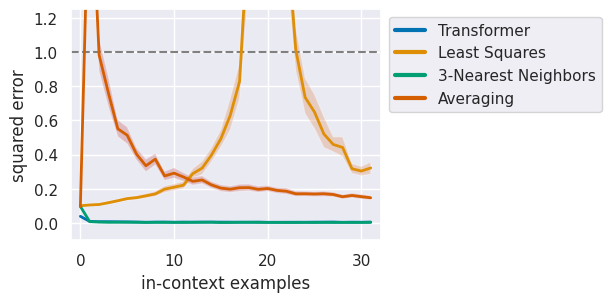

In [5]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [6]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [7]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [8]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [9]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs,mode="test")
#ys = task.evaluate(xs,mode="train")

In [10]:
print(xs[0][0])

tensor([ 0.0995, -0.3037, -0.2248, -0.3239, -1.0667,  2.5566, -1.4804,  0.8702,
         1.6438, -0.3703,  0.2049, -0.1800, -0.2937, -0.2768, -0.2846,  0.5295,
         1.4542,  0.7001, -0.7736,  0.7791])


In [11]:
print(ys[0][0])

tensor(-0.0257)


In [12]:
with torch.no_grad():
    pred = model(xs, ys)

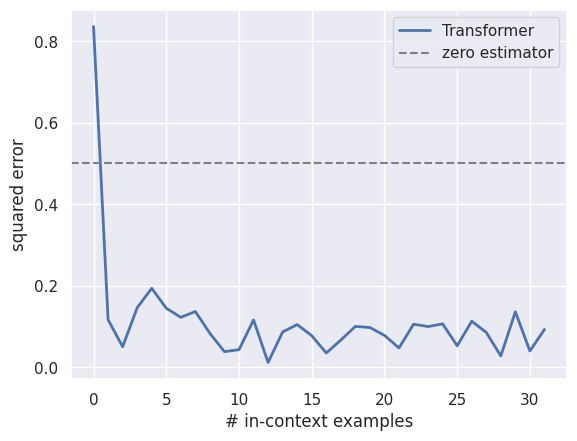

In [14]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "sine_regression": 1.0,
    "sine2cosine":1,
    "sine2periodic":1,
    "poly_function_regression":125,
    "hard_sine2sawtooth":0.5,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [15]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2, mode="test")
#ys2 = task.evaluate(xs2, mode="train")
with torch.no_grad():
    pred2 = model(xs2, ys2)

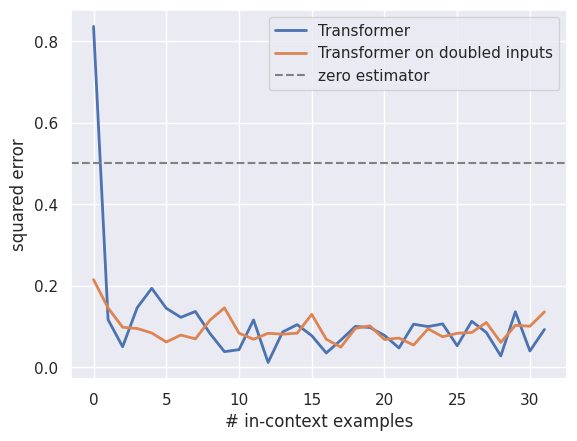

In [16]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [17]:
with torch.no_grad():
    # 获取模型中参数所在的设备
    device = next(model.parameters()).device

    # 构造输入为全 0 的向量
    zero_xs = torch.zeros_like(xs).to(device)
    ys_on_device = torch.ones_like(ys).to(device)

    pred_zero = model(zero_xs, ys_on_device)

    print("模型在输入为 0 时的预测结果：")
    print(pred_zero.cpu())
    print(ys_on_device.cpu())
    print(zero_xs)


模型在输入为 0 时的预测结果：
tensor([[0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905],
        [0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905],
        [0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905],
        ...,
        [0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905],
        [0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905],
        [0.7668, 0.9747, 0.9724,  ..., 0.9870, 0.9884, 0.9905]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 